In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vn30f_1min = pd.read_csv(r"../data/VN30F1M_1min_cleaned.csv",parse_dates=[0],index_col=0)
vn30_1min = pd.read_csv(r"../data/VN30_1min_cleaned.csv",parse_dates=[0],index_col=0)

In [61]:
vn30f_close = vn30f_1min[['close', 'days_to_maturity', 'day_of_week', 'is_morning', 'eod_open_interest']]
vn30_close = vn30_1min['close'].to_frame()
df = vn30_close.merge(vn30f_close, how='left', left_index=True, right_index=True,  suffixes=('_spot', '_future'))

In [62]:
df.head()

,close_spot,close_future,days_to_maturity,day_of_week,is_morning,eod_open_interest
2020-12-30 09:16:00,1059.88,1069.4,16,2,1,42216.0
2020-12-30 09:17:00,1061.00,1069.1,16,2,1,42216.0
2020-12-30 09:18:00,1061.40,1069.4,16,2,1,42216.0
2020-12-30 09:19:00,1062.44,1069.6,16,2,1,42216.0
2020-12-30 09:20:00,1062.43,1070.2,16,2,1,42216.0


## Examining Distribution of Futures to Spot Price Ratio

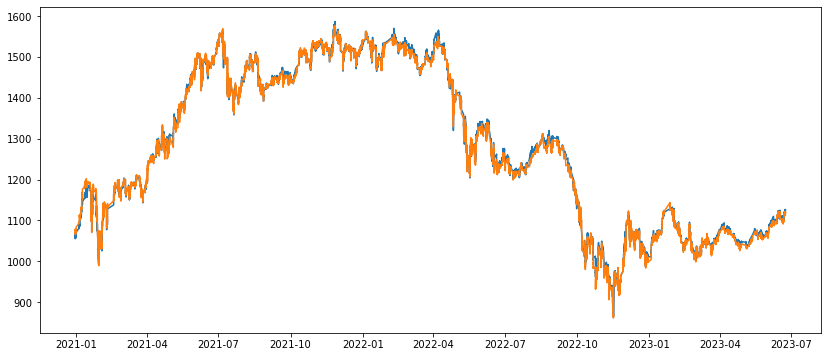

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df[["close_spot", "close_future"]])
plt.show()

In [6]:
df["future_to_spot"] = df["close_future"] / df["close_spot"]

In [7]:
print("Percent of times futures to spot ratio is greater than 1")
print(len(df[df["future_to_spot"] < 1]) / len(df))

Percent of times futures to spot ratio is greater than 1
0.667194962780224


In [8]:
df["future_to_spot"].describe()

count    139442.000000
mean          0.998054
std           0.005326
min           0.963103
25%           0.994986
50%           0.998270
75%           1.000909
max           1.039865
Name: future_to_spot, dtype: float64

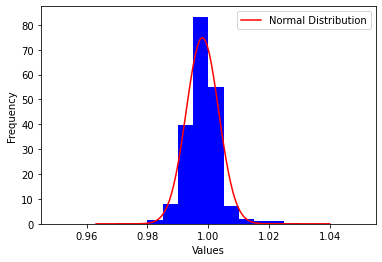

The distribution is not normal, the p-value is 0.0


/Users/nambuismbp/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
import scipy.stats as stats
from scipy.stats import norm

plt.hist(df["future_to_spot"], bins = 20, density=True, range = (0.95, 1.05), color='blue')

# Generate the normal distribution curve
x = np.linspace(np.min(df["future_to_spot"]), np.max(df["future_to_spot"]), 100)
y = norm.pdf(x, np.mean(df["future_to_spot"]), np.std(df["future_to_spot"]))

plt.plot(x, y, 'r-', label='Normal Distribution')
# Set labels and legend
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Shapiro-Wilk test
_, shapiro_pvalue = stats.shapiro(df["future_to_spot"])
if shapiro_pvalue < 0.05:
    print(f"The distribution is not normal, the p-value is {shapiro_pvalue}")

## Examining Changes in Futures to Spot Price Ratio at Maturity

<BarContainer object of 32 artists>

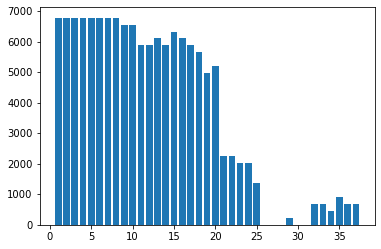

In [10]:
plt.bar(x=df["days_to_maturity"].value_counts().index, height=df["days_to_maturity"].value_counts().values)

In [11]:
maturity_groups = df.groupby(df["days_to_maturity"])

In [12]:
days_to_maturity = maturity_groups["future_to_spot"].mean().index
mean_future_to_spot = maturity_groups["future_to_spot"].mean().values
std_future_to_spot = maturity_groups["future_to_spot"].std().values

In [13]:
days_to_maturity[:20]

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', name='days_to_maturity')

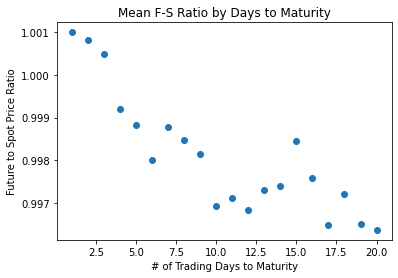

In [14]:
plt.scatter(days_to_maturity[:20], mean_future_to_spot[:20])
plt.ylabel("Future to Spot Price Ratio")
plt.xlabel("# of Trading Days to Maturity")
plt.title("Mean F-S Ratio by Days to Maturity")
plt.show()

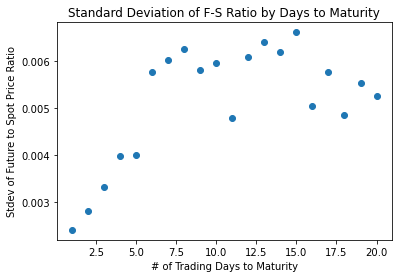

In [15]:
plt.scatter(days_to_maturity[:20], std_future_to_spot[:20])
plt.ylabel("Stdev of Future to Spot Price Ratio")
plt.xlabel("# of Trading Days to Maturity")
plt.title("Standard Deviation of F-S Ratio by Days to Maturity")
plt.show()

## Correlations between Changes in Spot and Futures Prices at Varying Maturity

In [16]:
df.head()

,close_spot,close_future,days_to_maturity,day_of_week,is_morning,future_to_spot
2020-12-30 09:16:00,1059.88,1069.4,16,2,1,1.008982
2020-12-30 09:17:00,1061.00,1069.1,16,2,1,1.007634
2020-12-30 09:18:00,1061.40,1069.4,16,2,1,1.007537
2020-12-30 09:19:00,1062.44,1069.6,16,2,1,1.006739
2020-12-30 09:20:00,1062.43,1070.2,16,2,1,1.007313


In [23]:
intervals = [1, 5, 10, 15, 30, 60, 120]
maturity_range = np.array(range(1, 21))

# A new dataframe with x-axis being days to maturity; y-axis being correlation of price changes at different interval
corr_df = pd.DataFrame(index = maturity_range)

In [24]:
for interval in intervals:
    corr_ls = []
    for day in maturity_range:
        group = df[df["days_to_maturity"] == day]
        spot_close_change = group.groupby(group.index.date)["close_spot"].pct_change(interval).dropna()
        future_close_change = group.groupby(group.index.date)["close_future"].pct_change(interval).dropna()
        corr = np.corrcoef(spot_close_change.values, future_close_change.values)
        corr_ls.append(corr[0][1])
    corr_df[str(interval)+ " min"] = corr_ls

In [25]:
corr_df.head()

,1 min,5 min,10 min,15 min,30 min,60 min,120 min
1,0.334837,0.660834,0.753462,0.800065,0.851864,0.875655,0.904576
2,0.359905,0.697469,0.782210,0.816639,0.866398,0.931930,0.970951
3,0.378108,0.671692,0.752557,0.805711,0.892632,0.951509,0.980968
4,0.414357,0.723241,0.808548,0.833736,0.872721,0.927060,0.954900
5,0.455980,0.726974,0.799457,0.826642,0.876584,0.920399,0.945306


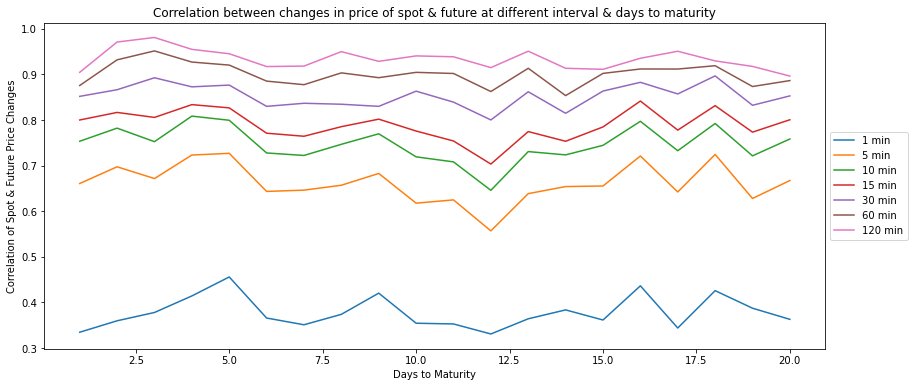

In [26]:
plt.figure(figsize=(14, 6))
for column in corr_df.columns:
    plt.plot(corr_df[column], label=column)

plt.xlabel("Days to Maturity")
plt.ylabel("Correlation of Spot & Future Price Changes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Correlation between changes in price of spot & future at different interval & days to maturity")
plt.show()

## Examining Future to Spot Ratio with Other Time Characteristics

In [27]:
days_of_week = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri"}

for i in days_of_week.keys():
    ratios = df[df["day_of_week"] == i]["future_to_spot"]
    print(days_of_week[i])
    print(f"Mean: {round(ratios.mean(), 5)}", f"; Stdev: {round(ratios.std(), 5)}")

Mon
Mean: 0.99792 ; Stdev: 0.00549
Tue
Mean: 0.99831 ; Stdev: 0.00532
Wed
Mean: 0.99823 ; Stdev: 0.00544
Thu
Mean: 0.99815 ; Stdev: 0.005
Fri
Mean: 0.99765 ; Stdev: 0.00534


In [30]:
print("Morning mean:")
print(df[df["is_morning"] == 1]["future_to_spot"].mean())

print("Afternoon mean:")
print(df[df["is_morning"] == 0]["future_to_spot"].mean())

Morning mean:
0.9979412473139536
Afternoon mean:
0.9982207015904142


## Examining Direction of Spot vs. Future Price Change at Different Time Interval

In [31]:
df

,close_spot,close_future,days_to_maturity,day_of_week,is_morning,future_to_spot
2020-12-30 09:16:00,1059.88,1069.4,16,2,1,1.008982
2020-12-30 09:17:00,1061.00,1069.1,16,2,1,1.007634
2020-12-30 09:18:00,1061.40,1069.4,16,2,1,1.007537
2020-12-30 09:19:00,1062.44,1069.6,16,2,1,1.006739
2020-12-30 09:20:00,1062.43,1070.2,16,2,1,1.007313
...,...,...,...,...,...,...
2023-06-23 14:26:00,1125.24,1117.4,20,4,0,0.993033
2023-06-23 14:27:00,1125.39,1118.1,20,4,0,0.993522
2023-06-23 14:28:00,1125.28,1119.5,20,4,0,0.994864
2023-06-23 14:29:00,1125.91,1120.5,20,4,0,0.995195


In [32]:
intervals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60]
pct_same_sign = {}

for interval in intervals:
    spot_change = df.groupby(df.index.date)["close_spot"].pct_change(interval).dropna()
    future_change = df.groupby(df.index.date)["close_future"].pct_change(interval).dropna()
    same_sign = np.sign(spot_change) == np.sign(future_change)
    
    pct_same_sign[interval] = same_sign.mean() * 100

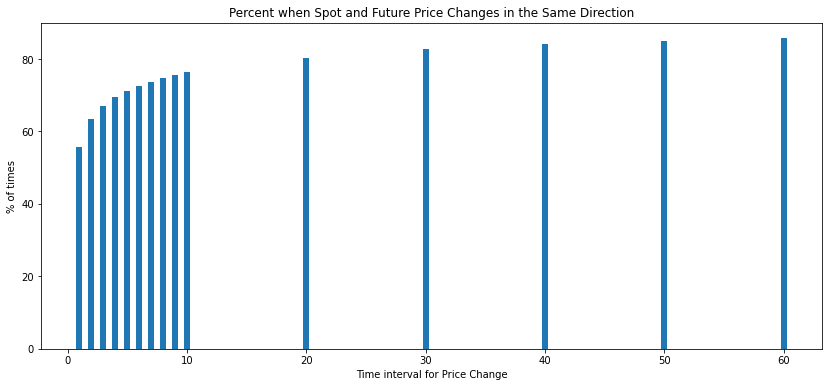

In [33]:
plt.figure(figsize=(14,6))
plt.bar(pct_same_sign.keys(), pct_same_sign.values(), width = 0.5)
plt.xlabel("Time interval for Price Change")
plt.ylabel("% of times")
plt.title("Percent when Spot and Future Price Changes in the Same Direction")
plt.show()

## Checking Daily Pct Change

In [34]:
# Define a custom lambda function to calculate the percentage difference
pct_difference = lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100

# Apply the lambda function to each group and calculate the percentage difference
daily_pct_change  = df.groupby(df.index.date)['close_future'].apply(pct_difference)

In [35]:
print("Daily Pct Change of Futures Price Stats")
daily_pct_change.describe()

Daily Pct Change of Futures Price Stats


count    617.000000
mean      -0.040418
std        1.435933
min       -6.186570
25%       -0.642144
50%       -0.019433
75%        0.635559
max        9.382944
Name: close_future, dtype: float64

In [36]:
print("Percent of Times when Price Moves Materially")
print(len(daily_pct_change[(daily_pct_change > 0.35) | (daily_pct_change < -0.35)]) / len(daily_pct_change))

Percent of Times when Price Moves Materially
0.7050243111831442


## When prices move materially / when spot crosses future prices

In [109]:
pct_change = df["close_future"].pct_change(60).dropna() * 100

In [110]:
print(len(pct_change[(pct_change > 0.35) | (pct_change < -0.35)]) / len(pct_change))

0.4582944713090643


In [48]:
df

,close_spot,close_future,days_to_maturity,day_of_week,is_morning,future_to_spot
2020-12-30 09:16:00,1059.88,1069.4,16,2,1,1.008982
2020-12-30 09:17:00,1061.00,1069.1,16,2,1,1.007634
2020-12-30 09:18:00,1061.40,1069.4,16,2,1,1.007537
2020-12-30 09:19:00,1062.44,1069.6,16,2,1,1.006739
2020-12-30 09:20:00,1062.43,1070.2,16,2,1,1.007313
...,...,...,...,...,...,...
2023-06-23 14:26:00,1125.24,1117.4,20,4,0,0.993033
2023-06-23 14:27:00,1125.39,1118.1,20,4,0,0.993522
2023-06-23 14:28:00,1125.28,1119.5,20,4,0,0.994864
2023-06-23 14:29:00,1125.91,1120.5,20,4,0,0.995195


In [51]:
crossover_up = 0
crossover_down = 0

# Checking number of times futures to spot ratio goes from below to above 1 and vice versa
for i in range(1, len(df["future_to_spot"])):
    if df["future_to_spot"][i - 1] < 1 and df["future_to_spot"][i] > 1:
        crossover_up += 1
    elif df["future_to_spot"][i - 1] > 1 and df["future_to_spot"][i] < 1:
        crossover_down += 1

In [56]:
print("Crossover Up: " + str(crossover_up))
print("Crossover Down: " + str(crossover_down))
print("Pct overall: " + str((crossover_up + crossover_down)/len(df["future_to_spot"])))

Crossover Up: 3419
Crossover Down: 3420
Pct overall: 0.04904548127536897


## Examining Open Interest

In [86]:
daily_open_interest = df.groupby(df.index.date)["eod_open_interest"].mean()

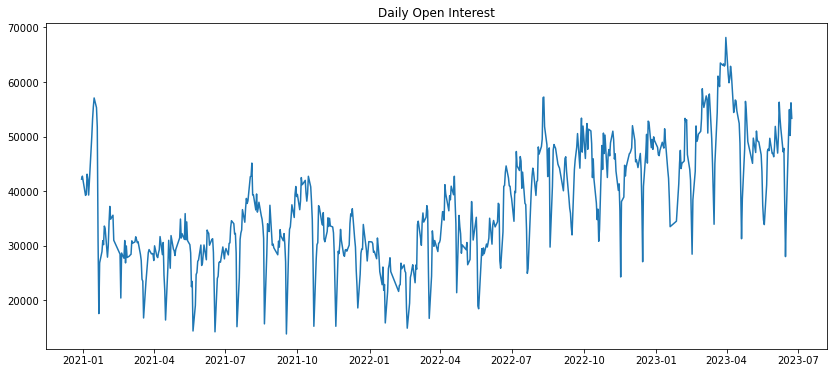

In [88]:
plt.figure(figsize=(14,6))
plt.plot(daily_open_interest)
plt.title("Daily Open Interest")
plt.show()